# PROYECTO FINAL OPERADORES INEFICIENTES

El servicio de telefonía virtual CallMeMaybe está desarrollando una nueva función que brindará a los supervisores y las supervisores información sobre los operadores menos eficaces. Se considera que un operador es ineficaz si tiene una gran cantidad de llamadas entrantes perdidas (internas y externas) y un tiempo de espera prolongado para las llamadas entrantes.

Vamos a utilizar dos data sets donde tenemos información de las llamadas y los usuarios con sus planes tarifarios, exploraremos un poco la calidad de estos datos, haremos un analisis sencillos de estos y desarrollaremos algunas hipotesis.

In [141]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.proportion import proportions_ztest

## Preparación de datos

In [142]:
clients = pd.read_csv('data/telecom_clients_us.csv')
calls = pd.read_csv('data/telecom_dataset_us.csv')

In [143]:
calls.info()
print()
clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              53902 non-null  int64  
 1   date                 53902 non-null  object 
 2   direction            53902 non-null  object 
 3   internal             53785 non-null  object 
 4   operator_id          45730 non-null  float64
 5   is_missed_call       53902 non-null  bool   
 6   calls_count          53902 non-null  int64  
 7   call_duration        53902 non-null  int64  
 8   total_call_duration  53902 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.3+ MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      732 non-null    int64 
 1   tariff_plan  732 non-null    object
 2

In [144]:
calls.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4
1,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,1
3,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,False,1,10,18
4,166377,2019-08-05 00:00:00+03:00,out,False,880022.0,True,3,0,25


In [145]:
clients.head()

,user_id,tariff_plan,date_start
0,166713,A,2019-08-15
1,166901,A,2019-08-23
2,168527,A,2019-10-29
3,167097,A,2019-09-01
4,168193,A,2019-10-16


In [146]:
calls['date'] = pd.to_datetime(calls['date'])
clients['date_start'] = pd.to_datetime(clients['date_start'])


In [147]:
calls['internal'].value_counts(dropna=False)

internal
False    47621
True      6164
NaN        117
Name: count, dtype: int64

In [148]:
calls['internal'] = calls['internal'].fillna(False).astype(bool)


calls['operator_id'] = calls['operator_id'].astype('Int64')


/tmp/ipykernel_1977/3259521089.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  calls['internal'] = calls['internal'].fillna(False).astype(bool)


In [149]:
calls.info()
print()
clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype                    
---  ------               --------------  -----                    
 0   user_id              53902 non-null  int64                    
 1   date                 53902 non-null  datetime64[ns, UTC+03:00]
 2   direction            53902 non-null  object                   
 3   internal             53902 non-null  bool                     
 4   operator_id          45730 non-null  Int64                    
 5   is_missed_call       53902 non-null  bool                     
 6   calls_count          53902 non-null  int64                    
 7   call_duration        53902 non-null  int64                    
 8   total_call_duration  53902 non-null  int64                    
dtypes: Int64(1), bool(2), datetime64[ns, UTC+03:00](1), int64(4), object(1)
memory usage: 3.0+ MB

<class 'pandas.core.frame.DataFrame'>
RangeI

Revisando los datos descubrimos lo siguiente: 
1.-Los datos que deberian de ser fechas tenian un tipo de dato que no correspondía.
2.-El campo internal tenia valores nulos, pero al ser un numero muy pequeño no consideramos problematico remplazar los valores por False.
3.-El campo operator_id tambien contiene valores nulos y ademas estaba asignado como valor Float, cambiamos el campo a Int que parece lo adecuado por el tipo de dato, con respecto a los valores nulos los mantuvimos por que probablemente se pieden con las agrupaciones futuras.


## EDA

1. Estadísticas descriptivas

Hacemos un sencillo describe para los numeros generales



In [150]:
calls.describe()


,user_id,operator_id,calls_count,call_duration,total_call_duration
count,53902.000000,45730.0,53902.000000,53902.000000,53902.000000
mean,167295.344477,916535.993002,16.451245,866.684427,1157.133297
std,598.883775,21254.123136,62.917170,3731.791202,4403.468763
min,166377.000000,879896.0,1.000000,0.000000,0.000000
25%,166782.000000,900788.0,1.000000,0.000000,47.000000
50%,167162.000000,913938.0,4.000000,38.000000,210.000000
75%,167819.000000,937708.0,12.000000,572.000000,902.000000
max,168606.000000,973286.0,4817.000000,144395.000000,166155.000000


Revisamos la proporción de llamadas perdidas

In [151]:
calls['is_missed_call'].value_counts(normalize=True)

is_missed_call
False    0.562762
True     0.437238
Name: proportion, dtype: float64

2. Tendencias temporales

Evolución de llamadas en el tiempo.

Diferenciar entrantes (in) y salientes (out).

<Axes: xlabel='date'>

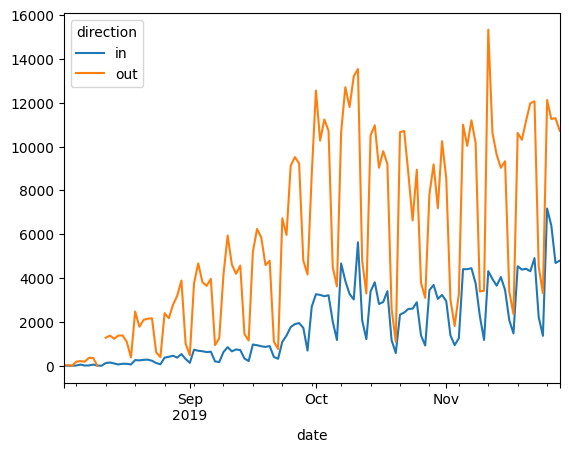

In [152]:
calls.groupby(['date','direction'])['calls_count'].sum().unstack().plot()



3. Operadores


Ranking de operadores con más llamadas

In [153]:
calls.groupby('operator_id')['calls_count'].sum().sort_values(ascending=False).head(10).reset_index()

,operator_id,calls_count
0,885876,66049
1,885890,66016
2,929428,24572
3,925922,22210
4,908640,16699
5,929426,12041
6,879898,7974
7,945286,7919
8,945302,7059
9,893804,6570


Métricas nuevas


Tiempo promedio de espera (diferencia entre total_call_duration y call_duration)

In [154]:
calls['waiting_time'] = calls['total_call_duration'] - calls['call_duration']

Promedio de llamadas salientes por operador

In [155]:
outgoing = (
    calls[calls['direction']=='out']
    .groupby('operator_id')['calls_count']
    .mean().reset_index()
)

outgoing.head()    

,operator_id,calls_count
0,879896,10.200000
1,879898,42.010695
2,880020,3.285714
3,880022,3.102941
4,880026,13.486034


Hacemos una nueva tabla con valores nuevos y agrupado por el operador

In [156]:


# Agrupar por operador
operator_stats = (
    calls.groupby(['user_id','operator_id'])
    .agg(
        total_calls = ('calls_count', 'sum'),
        missed_calls = ('is_missed_call', 'sum'),
        missed_rate = ('is_missed_call', 'mean'),
        avg_waiting_time = ('waiting_time', 'mean'),
        calls_duration = ('call_duration', 'mean'),
        outgoing_calls = ('calls_count', lambda x: calls.loc[x.index, 'direction'].eq('out').sum())
    ).reset_index()
)

# Calcular proporción de llamadas salientes
operator_stats['outgoing_rate'] = operator_stats['outgoing_calls'] / operator_stats['total_calls']

# Revisar las primeras filas
print(operator_stats.head())

   user_id  operator_id  total_calls  missed_calls  missed_rate  \
0   166377       880020           54             7     0.318182   
1   166377       880022          219            33     0.434211   
2   166377       880026         2439            94     0.474747   
3   166377       880028         2906            91     0.402655   
4   166377       881278           20             7     0.875000   

   avg_waiting_time  calls_duration  outgoing_calls  outgoing_rate  
0         15.181818      104.090909              14       0.259259  
1         57.565789      240.842105              68       0.310502  
2        121.171717      856.939394             179       0.073391  
3        210.592920      746.265487             181       0.062285  
4          9.750000       58.125000               8       0.400000  


Con este nuevo data set perdemos los operator_id que estaban nulos y nos sirve para poder revisar pruebas de hipotesis, pero primero agreguemos la tabla de los clientes con sus tipos de tarifas.

In [157]:
operator_stats = operator_stats.merge(
    clients[['user_id','tariff_plan']],
    on='user_id',
    how='left'
)

# Revisar
operator_stats.head()

,user_id,operator_id,total_calls,missed_calls,missed_rate,avg_waiting_time,calls_duration,outgoing_calls,outgoing_rate,tariff_plan
0,166377,880020,54,7,0.318182,15.181818,104.090909,14,0.259259,B
1,166377,880022,219,33,0.434211,57.565789,240.842105,68,0.310502,B
2,166377,880026,2439,94,0.474747,121.171717,856.939394,179,0.073391,B
3,166377,880028,2906,91,0.402655,210.592920,746.265487,181,0.062285,B
4,166377,881278,20,7,0.875000,9.750000,58.125000,8,0.400000,B


In [158]:
operator_stats.describe()

,user_id,operator_id,total_calls,missed_calls,missed_rate,avg_waiting_time,calls_duration,outgoing_calls,outgoing_rate
count,1092.00000,1092.0,1092.000000,1092.000000,1092.000000,1092.000000,1092.000000,1092.000000,1092.000000
mean,167464.39011,925517.543956,707.911172,14.210623,0.314304,215.446189,648.206312,29.044872,0.194845
std,608.51867,22854.532209,3181.539177,20.355762,0.231363,504.915578,1195.988200,40.288292,0.242218
min,166377.00000,879896.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,166952.75000,906393.5,11.000000,1.000000,0.125000,23.058824,76.655556,1.000000,0.016756
50%,167497.00000,925105.0,78.500000,6.000000,0.333333,46.259878,239.806767,11.000000,0.096523
75%,168062.00000,944211.5,558.750000,21.000000,0.461538,155.541011,659.824661,44.000000,0.293949
max,168606.00000,973286.0,66049.000000,135.000000,1.000000,5907.443038,14620.545455,246.000000,1.000000


Ahora estamos listos para unas graficas exploratorias

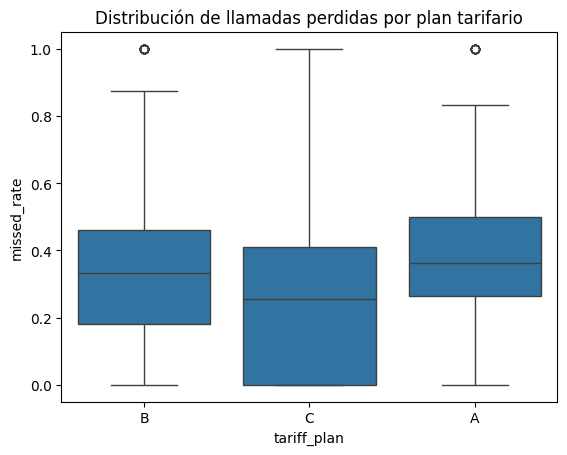

In [159]:

# Comparar tasas de llamadas perdidas
sns.boxplot(x='tariff_plan', y='missed_rate', data=operator_stats)
plt.title("Distribución de llamadas perdidas por plan tarifario")
plt.show()


Segun esto el plan C es el que mayor numero de llamadas perdidas tiene.

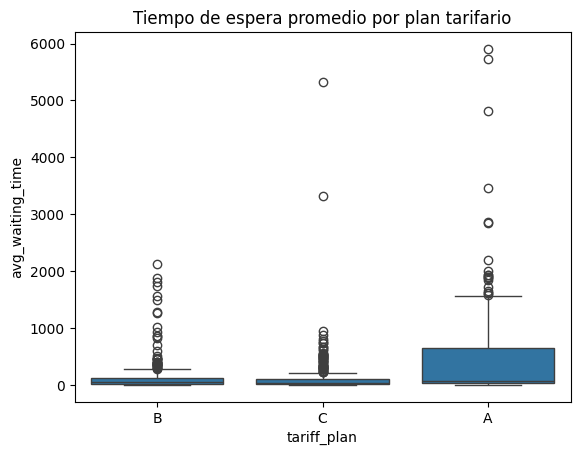

In [160]:
#Comparar tiempos de espera promedio
sns.boxplot(x='tariff_plan', y='avg_waiting_time', data=operator_stats)
plt.title("Tiempo de espera promedio por plan tarifario")
plt.show()


Para esta grafica de tiempo de espera pareciera que el A es el que mas tiene pero hay demasiados valores atipicos entonces las graficas estan muy cortas, vamos a limitartlas un poco para que se vean mejor.

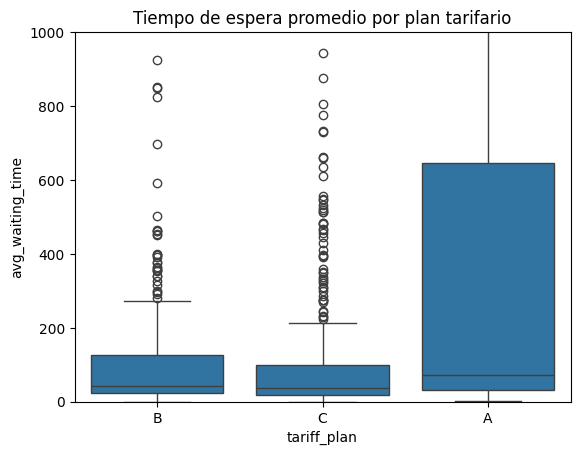

In [173]:
sns.boxplot(x='tariff_plan', y='avg_waiting_time', data=operator_stats)
plt.title("Tiempo de espera promedio por plan tarifario")
plt.ylim(0, 1000)  # ejemplo: enfocar en 0–300 segundos
plt.show()



Ya con el limite a 1000 el plan A es por mucho el que tiene mas tiempos de espera.

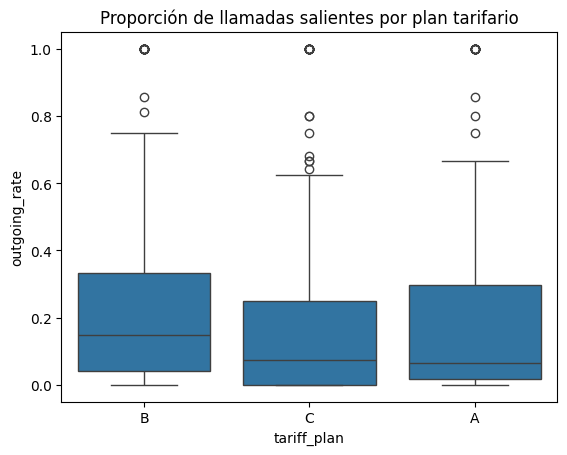

In [162]:
# Comparar tiempos de espera promedio
sns.boxplot(x='tariff_plan', y='outgoing_rate', data=operator_stats)
plt.title("Proporción de llamadas salientes por plan tarifario")
plt.show()


PArece que los tiempos de espera no son similares en los 3 planes, eso significa que A tiene mas por el numero de llamadas que maneja.

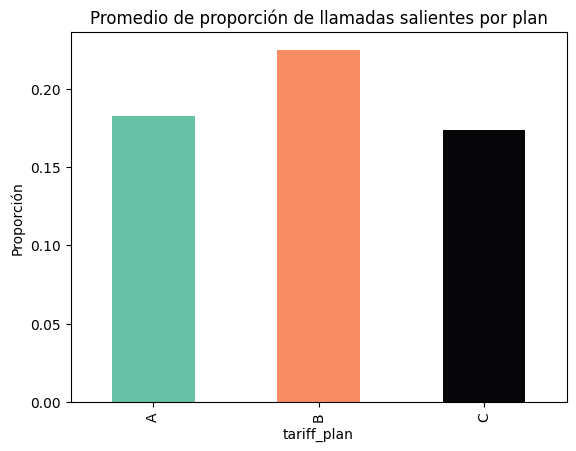

In [163]:
outgoing_mean = operator_stats.groupby('tariff_plan')['outgoing_rate'].mean()
outgoing_mean.plot(kind='bar', color=['#66c2a5','#fc8d62',"#060608"])
plt.title("Promedio de proporción de llamadas salientes por plan")
plt.ylabel("Proporción")
plt.show()


Para la grafica de llamadas salientes promedio tenemos a B como el superiroo, puede que sea el mas eficiente pero eso no lo estamos midiendo esta vez.

## Que es un operador ineficiente

Vamos a hacer una regla, ayudandonos de una función vamos a establecer que factores son los que influyen para identificar a un operador ineficas y con esta función vamos a a poder decir los limites de cada factor, asi podria ser dinamico si el criterio cambai con el paso de tiempo. Podemos dejar unos valores por default pero al llamar a la función vamos a determinar nuevos.

In [164]:
def flag_inefficient_operators(df, missed_thr=0.6, wait_thr=100, out_thr=0.1, min_flags=2):
    """
    Marca operadores ineficaces según umbrales.
    
    Parámetros:
    -----------
    df : DataFrame
        Tabla con métricas por operador.
    missed_thr : float
        Umbral de tasa de llamadas perdidas.
    wait_thr : int o float
        Umbral de tiempo de espera promedio (segundos).
    out_thr : float
        Umbral de proporción de llamadas salientes.
    min_flags : int
        Número mínimo de condiciones problemáticas para marcar como ineficaz.
    
    Retorna:
    --------
    DataFrame con columna extra 'inefficient' (True/False).
    """
    df = df.copy()
    df['inefficient'] = (
        (df['missed_rate'] > missed_thr).astype(int) +
        (df['avg_waiting_time'] > wait_thr).astype(int) +
        (df['outgoing_rate'] < out_thr).astype(int)
    ) >= min_flags
    return df

In [165]:
# Evaluar con los valores determinados por mi 
result = flag_inefficient_operators( operator_stats,missed_thr= 0.6, wait_thr=150, out_thr=0.4, min_flags=2)

total_ops = len(result)

# Ineficaces (True en la columna 'inefficient')
ineficaces = result['inefficient'].sum()

# Porcentaje
porcentaje = (ineficaces / total_ops) * 100

# Reporte
print(f"Total de operadores: {total_ops}")
print(f"Operadores ineficaces: {ineficaces}")
print(f"Porcentaje de ineficaces: {porcentaje:.2f}%")


Total de operadores: 1092
Operadores ineficaces: 291
Porcentaje de ineficaces: 26.65%


In [166]:
reporte_tarifas = (
    result.groupby('tariff_plan')['inefficient']
    .agg(
        total_ops='count',
        ineficaces='sum'
    )
    .reset_index()
)


reporte_tarifas['porcentaje_ineficaces'] = (
    reporte_tarifas['ineficaces'] / reporte_tarifas['total_ops'] * 100
)

print(reporte_tarifas)

  tariff_plan  total_ops  ineficaces  porcentaje_ineficaces
0           A        310         131              42.258065
1           B        395          92              23.291139
2           C        387          68              17.571059


/tmp/ipykernel_1977/2293954410.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


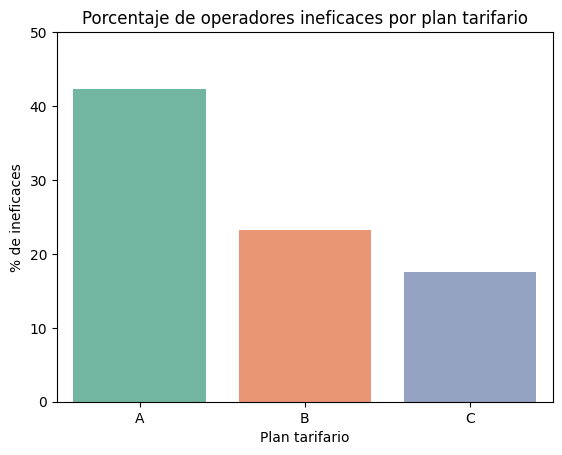

In [167]:
sns.barplot(
    data=reporte_tarifas,
    x='tariff_plan',
    y='porcentaje_ineficaces',
    palette='Set2'
)

plt.title("Porcentaje de operadores ineficaces por plan tarifario")
plt.xlabel("Plan tarifario")
plt.ylabel("% de ineficaces")
plt.ylim(0, 50)  # porque es porcentaje
plt.show()

PArece que tenemos un plan tarifario ganadaor en cuenta a operadores ineficases.

## Pruebas de Hipotesis

Vamos a probar unas hipotesis, primero queremos realmente comprobar que el plan A es el peor contra los otros 2 planes.
Despues vamoos a validar algunos de los campos medibles y como ya tenemos una separación de eficientes e ineficientes vamos a validar que si es correcta.

### Planes tarifarios e ineficiencia

H₀: la proporción de operadores ineficaces es igual en los diferentes tariff_plan.

H₁: el plan A tiene una proporción mayor de operadores ineficaces.
Aquí aplicamos un z-test para dos proporciones (Plan A vs Plan B, Plan A vs Plan C).

In [168]:

tabla = result.groupby('tariff_plan')['inefficient'].agg(['sum','count'])
print(tabla)

# Plan A vs Plan B
ineficaces = [tabla.loc['A','sum'], tabla.loc['B','sum']]
totales = [tabla.loc['A','count'], tabla.loc['B','count']]

stat, pval = proportions_ztest(ineficaces, totales, alternative='larger')

print("Z-stat:", stat)
print("p-valor:", pval)


             sum  count
tariff_plan            
A            131    310
B             92    395
C             68    387
Z-stat: 5.375203808431894
p-valor: 3.824805233115786e-08


El p valor es sumamente bajo, Rechazamos la hipotesis nula  dodne dice que la proporción en ambas tarifas es igual, en el Plan A es significativamente mayor el numero de operadores ineficases

In [169]:
# Plan A vs Plan C
ineficaces_2 = [tabla.loc['A','sum'], tabla.loc['C','sum']]
totales_2 = [tabla.loc['A','count'], tabla.loc['C','count']]

stat2, pval2 = proportions_ztest(ineficaces_2, totales_2, alternative='larger')

print("Z-stat:", stat2)
print("p-valor:", pval2)


Z-stat: 7.171003184829296
p-valor: 3.7225085996221907e-13


Mismo caso que con A vs B, A vs C tiene un Z valor muy alto que indica mucha diferencia y un p valor muy  muy bajo que nos hace rechazar la hipotesis nula ya que siu hay gran diferencia.

### Hipótesis 2: ¿Los operadores ineficaces tienen significativamente mayor missed_rate que los eficientes?

H₀ (nula): No hay diferencia significativa en la tasa de llamadas perdidas (missed_rate) entre operadores ineficaces y eficientes.
H₁ (alternativa): Los operadores ineficaces tienen un missed_rate significativamente mayor.

In [170]:
missed_ineficientes = result[result['inefficient']]['missed_rate']
missed_eficientes   = result[~result['inefficient']]['missed_rate']

# Prueba t de Welch (varianzas desiguales)
t_stat2, p_val2 = stats.ttest_ind(missed_ineficientes, missed_eficientes, equal_var=False)

print("T-stat:", t_stat2)
print("p-valor:", p_val2)

T-stat: 16.35066543663091
p-valor: 1.0289653132002176e-52


el T valor es sumamente alto, las medias de missed rate entre ambos grupos es muy diferente, P valor es muy baja, queire decir que si hay una relación un alto numero de missed calls, vamos a rechazar la hipotesis nula 

### Hipótesis 3: ¿Los operadores ineficaces tienen tiempo de espera mayores?

H₀: el avg_waiting_time es igual entre operadores ineficaces y eficientes.
H₁: los ineficaces tienen mayor avg_waiting_time.


In [171]:
wait_ineficientes = result[result['inefficient']]['avg_waiting_time']
wait_eficientes   = result[~result['inefficient']]['avg_waiting_time']

# Prueba t de Welch (varianzas desiguales)
t_stat3, p_val3 = stats.ttest_ind(wait_ineficientes, wait_eficientes, equal_var=False)

print("T-stat:", t_stat3)
print("p-valor:", p_val3)


T-stat: 13.725243198868688
p-valor: 2.196185486755059e-33


### Hipótesis 4: ¿Los operadores ineficaces tienen un tiempo de llamada mayor?

H₀: el call_duration es igual entre operadores ineficaces y eficientes.
H₁: los ineficaces tienen mayor call_duration.


In [172]:
duration_ineficientes = result[result['inefficient']]['calls_duration']
duration_eficientes   = result[~result['inefficient']]['calls_duration']

# Prueba t de Welch (varianzas desiguales)
t_stat4, p_val4 = stats.ttest_ind(duration_ineficientes, duration_eficientes, equal_var=False)

print("T-stat:", t_stat4)
print("p-valor:", p_val4)


T-stat: 13.622228752031363
p-valor: 3.0644474183714564e-33


## 5 Conclusiones y recomendaciones.

Hicimos una exploración y encontramos varias cosas, enumeremoslas:

1.- El plan A es que contiene mas operadores ineficaces.
2.- Hay varios factores que influyen en que definimos como ineficaz pero el que mas afecta al plan A es el tiempo de espera.
3.- El plan C es el que mayor llamadas perdidas tiene.
4.- El plan A tiene el mayor numero de llamadas totales pero no es el que tiene el mayor numero de llamadas salientes.


Con esto podemos hacer algunas recomendaciones (y tal vez unas cuantas hipotesis mas)

Parece que lo que más afecta a la empresa son los tiempos de espera, pero también pareciera que con el plan A hay muchos casos de llamadas internas, habrá algún factor que provoque que los operadores de este plan no hagan menos llamadas de salida? y que esto está provocando que generen demasiados tiempo de espera?, como también pudimos observar el plan A tiene mayoy número de llamadas, habra una forma de que podamos equilibrar el número de llamadas entre los 3 planes? porque este puede ser un factor al aumento de tiempos de espera en este plan y por lo tanto saturación de los operadores de este plan.


### LINKS
Realice una presentaciónd e resumen en google slides, copio el link aqui:

https://docs.google.com/presentation/d/11qSnXgP-1ZxqLMeAPCdztEEs8GPppwP0JjFletkqTXY/edit?usp=sharing


Tambien hice uan exploiración por Tableau, aqui dejo el link:

https://public.tableau.com/views/ProyectoFinal_17590201621790/Dashboard1?:language=en-US&publish=yes&:sid=&:redirect=auth&:display_count=n&:origin=viz_share_link